In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import os
import tensorflow as tf
from IPython import display
from sklearn import metrics
import glob
import sys
from riotwatcher import RiotWatcher
import requests
import json

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

### Get all champs in game from static data file (.json)

In [2]:
champfile=os.path.join('lol_data','version6.24.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)

In [3]:
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]

# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [16]:
def _parse_function_win(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    target = parsed_features['targets']

    return  {'blue_champs':blue_champs, 'red_champs':red_champs}, target

In [32]:
def _parse_function_float(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.float32)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    target = parsed_features['targets']

    return  {'blue_champs':blue_champs, 'red_champs':red_champs}, target

#### Check the parse function worked

In [14]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('LOL_data','mix_tier',
                                          'lol_training_data',
                                          'blue_win_lol_training_data.tfrecords'))
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<DatasetV1Adapter shapes: ({blue_champs: (?,), red_champs: (?,)}, (1,)), types: ({blue_champs: tf.int64, red_champs: tf.int64}, tf.int64)>

In [15]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'blue_champs': array([ 15, 267, 266, 517,  43]),
  'red_champs': array([ 51, 268, 421,  78,  25])},
 array([1]))

## Model Functions

In [21]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True, batch_size=50,target="blue_win"):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    if target=='blue_win':
        ds = ds.map(_parse_function_win)
    else:
        ds = ds.map(_parse_function_float)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with vocabulary (all champions)

In [24]:
def construct_hero_categorical_columns(keys,vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

In [34]:
def train_linear_model(
    target,
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        target: Target to use for the model (determines whether float and classifier
          vs regressor)
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearEstimator` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods
    if target=='blue_win':
        head=tf.contrib.estimator.binary_classification_head()
    else:
        head=tf.contrib.estimator.regression_head()

    
    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_estimator = tf.estimator.LinearEstimator(
      head=head,
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
  
    training_input_fn =lambda: _input_fn([training_file],target=target)
    test_input_fn =lambda: _input_fn([test_file],target=target)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_estimator.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(evaluation_metrics['loss'])
        
        print('test loss', evaluation_metrics['loss'])

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training loss')
    plt.plot(test_acc,label='Test loss')
    plt.legend()
    plt.show()
    
    return linear_estimator


### Train a binary classification model for blue_win

Training model...
test inaccuracy 0.4712594151496887
test inaccuracy 0.46622657775878906
test inaccuracy 0.4620339274406433
test inaccuracy 0.46124982833862305
test inaccuracy 0.4617859125137329
test inaccuracy 0.4602656364440918
test inaccuracy 0.4595615267753601
test inaccuracy 0.4600095748901367
test inaccuracy 0.4593775272369385
test inaccuracy 0.45828133821487427
test inaccuracy 0.4579932689666748
test inaccuracy 0.457825243473053
test inaccuracy 0.4568411111831665
test inaccuracy 0.4563930034637451
test inaccuracy 0.4563770294189453
test inaccuracy 0.45677709579467773
test inaccuracy 0.4566250443458557
test inaccuracy 0.4564650058746338
test inaccuracy 0.4564010500907898
test inaccuracy 0.4571131467819214
Test set metrics:
accuracy 0.54288685
accuracy_baseline 0.5200432
auc 0.5558486
auc_precision_recall 0.52773905
average_loss 0.68803895
label/mean 0.4799568
loss 0.6880384
precision 0.5349629
prediction/mean 0.48506805
recall 0.36412436
global_step 50000
---


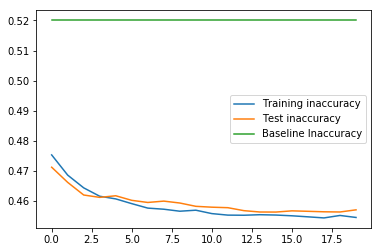

In [30]:
training_file = os.path.join('lol_data','mix_tier','lol_training_data','blue_win_lol_training_data.tfrecords')
test_file = os.path.join('lol_data','mix_tier','lol_test_data','blue_win_lol_test_data.tfrecords')

trained_win_linear_model = train_linear_model(
    target='blue_win',
    learning_rate=0.003,
    steps=5e4,
    batch_size=2000,
    feature_columns=construct_hero_categorical_columns(['blue_champs','red_champs'],
                                                       champ_vocab),
    training_file=training_file,
    test_file=test_file)

### Train a linear regression model for gold_diff

Training model...
test loss 0.9887446
test loss 0.98587656
test loss 0.9785894
test loss 0.9817295
test loss 0.98314995
test loss 0.99787784
test loss 0.9856019
test loss 0.98417854
test loss 0.98697287
test loss 0.98854595
test loss 0.9859332
test loss 0.98783123
test loss 0.9836778
test loss 0.99013275
test loss 0.97660494
test loss 0.989518
test loss 0.99399817
test loss 0.9867963
test loss 0.9910079
test loss 0.9838523
Test set metrics:
average_loss 0.9838521
label/mean -0.008977905
loss 0.9838523
prediction/mean -0.012593971
global_step 5000
---


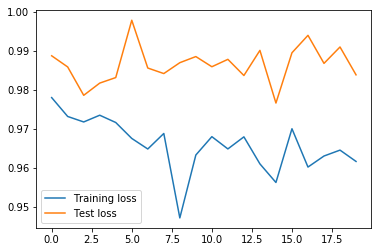

In [45]:
training_file = os.path.join('lol_data','mix_tier','lol_training_data',
                             'gold_diff_lol_training_data.tfrecords')
test_file = os.path.join('lol_data','mix_tier','lol_test_data',
                         'gold_diff_lol_test_data.tfrecords')

trained_gold_linear_model = train_linear_model(
    target='gold_diff',
    learning_rate=0.03,
    steps=5e3,
    batch_size=1000,
    feature_columns=construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab),
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [19]:
validation_file = os.path.join('lol_data','masters_tier','lol_training_data','lol_training_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_linear_model.evaluate(
            input_fn=validation_input_fn,
            steps=100)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.543
accuracy_baseline 0.5102
auc 0.56560886
auc_precision_recall 0.5488617
average_loss 0.68615097
label/mean 0.4898
loss 34.30755
precision 0.5322327
prediction/mean 0.50139517
recall 0.55287874
global_step 500000


## Define and train a DNN model

### Define feature column constructor functions

In [5]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [6]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Define model training function

In [13]:
def train_dnn_model(
    target,
    my_optimizer,
    hidden_units,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a deep neural network regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        hidden_units: A `list` of `ints` specifying the number of layers and number 
            of nodes per layer.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `DNNClassifer` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a dnn regressor object.
    dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      hidden_units=hidden_units,
      optimizer=my_optimizer
        )
  
    training_input_fn =lambda: _input_fn([training_file],batch_size=batch_size)
    test_input_fn =lambda: _input_fn([test_file],batch_size=batch_size)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['accuracy'])
        #print('training accuracy %f' %(evaluation_metrics['accuracy'])) 
        
        evaluation_metrics = dnn_classifier.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(evaluation_metrics['accuracy'])
        
        print('test accuracy %f' %(evaluation_metrics['accuracy']))

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training accuracy')
    plt.plot(test_acc,label='Test accuracy')
    plt.plot(evaluation_metrics['accuracy_baseline']*np.ones(periods))
    plt.legend()
    plt.show()
    
    return dnn_classifier


### Specify path to tfrecord files and construct feature colums

In [9]:
training_file = os.path.join('LOL_data','masters_tier','lol_training_data','lol_training_data.tfrecords')
test_file = os.path.join('LOL_data','masters_tier','lol_test_data', 'lol_test_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=4)

### Train model

Training model...
test accuracy 0.527685
test accuracy 0.542148
test accuracy 0.545606
test accuracy 0.545845
test accuracy 0.545186
test accuracy 0.545650
test accuracy 0.544918
test accuracy 0.546568
test accuracy 0.546046
test accuracy 0.545856
test accuracy 0.547410
test accuracy 0.548476
test accuracy 0.548538
test accuracy 0.549352
test accuracy 0.548358
test accuracy 0.548406
test accuracy 0.548832
test accuracy 0.548619
test accuracy 0.548961
test accuracy 0.549588
Test set metrics:
accuracy 0.54958797
accuracy_baseline 0.50366473
auc 0.568422
auc_precision_recall 0.5605323
average_loss 0.68605167
label/mean 0.50366473
loss 1978.1339
precision 0.5490022
prediction/mean 0.5075455
recall 0.5922823
global_step 3000
---


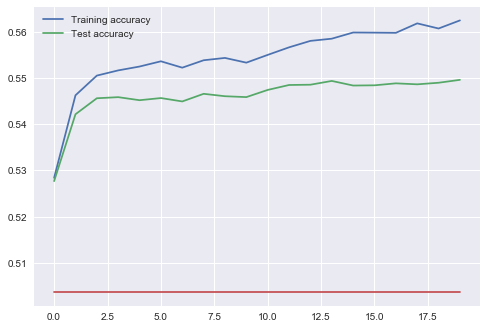

In [17]:
my_optimizer = tf.contrib.opt.AdamWOptimizer(weight_decay=0.0008, learning_rate=0.0025)
#my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

trained_dnn_model = train_dnn_model(
    my_optimizer = my_optimizer,
    hidden_units = [10,10],
    steps=3e3,
    batch_size=3000,
    feature_columns=embedding_feature_columns,
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [24]:
validation_file = os.path.join('LOL_data','masters_tier','lol_validation_data', 'lol_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dnn_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e3)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5495492
accuracy_baseline 0.50042677
auc 0.5685406
auc_precision_recall 0.5591297
average_loss 0.6860394
label/mean 0.50042677
loss 34.295567
precision 0.5458012
prediction/mean 0.507441
recall 0.5950433
global_step 3000


### Investigate embeding layer

In [79]:
champ_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

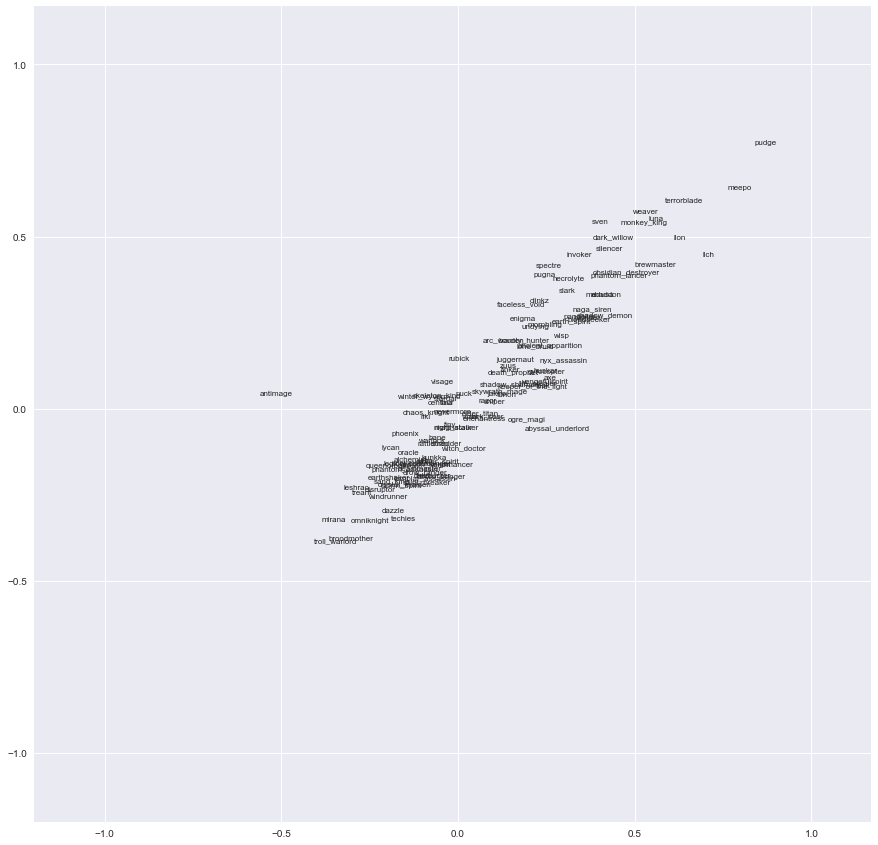

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
red_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/red_champs_embedding/embedding_weights')

blue_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/blue_heroes_embedding/embedding_weights')

for champ_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    red_vector = np.zeros(len(vocab))
    red_vector[champ_index] = 1
    blue_vector = np.zeros(len(vocab))
    blue_vector[champ_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    red_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    blue_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(blue_embedding_xy[0],
           blue_embedding_xy[3],
           champ_list[champ_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.ylim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.show() 

### Save a trained model later exploration, or for on-demand prediction of test cases

In [20]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    
    features = {'blue_champs':radiant_heroes, 'red_champs': dire_heroes}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

## Define and train dual head linear model

# Preprocessing, input functions, and linear training for DataFrame data format

### Train a dual head linear classifier and regressor

### Define model function

In [ ]:
def train_dualhead_linear_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a dual head linear model for a binary classifier and regressor
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearEstimator` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    win_head = tf.contrib.estimator.binary_classification_head(name=win_head)
    gold_head = tf.contrib.estimator.regressor_head(name=gold_head)
    head = multi_head([win_head,gold_head])
    linear_estimator = tf.estimator.LinearEstimator(
      head=head,
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
  
    training_input_fn =lambda: _input_fn([training_file])
    test_input_fn =lambda: _input_fn([test_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_estimator.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(1-evaluation_metrics['accuracy'])
                            
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(1-evaluation_metrics['accuracy'])
        
        print('test inaccuracy', 1-evaluation_metrics['accuracy'])

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training inaccuracy')
    plt.plot(test_acc,label='Test inaccuracy')
    plt.plot(evaluation_metrics['accuracy_baseline']*np.ones(periods),label='Baseline Inaccuracy')
    plt.legend()
    plt.show()
    
    return linear_estimator


In [ ]:
training_file = os.path.join('lol_data','masters_tier','lol_training_data','lol_training_data.tfrecords')
test_file = os.path.join('lol_data','masters_tier','lol_test_data','lol_test_data.tfrecords')

trained_gold_linear_model = train_dualhead_linear_model(
    learning_rate=0.003,
    steps=5e5,
    batch_size=2000,
    feature_columns=construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab),
    training_file=training_file,
    test_file=test_file)

In [21]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1554789124'